# Experiment: number of pointer moves

** Objective: ** Verify that the maximum number of moves required to insert a new point in the piecewise function is of the order of $O(\log n)$, where $n$ is the number of examples in a dataset.

In [63]:
%matplotlib inline
from __future__ import absolute_import, division, print_function, unicode_literals
from builtins import range

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set_style("white")

from functools import partial
from joblib import delayed, Parallel
from mmit import MaxMarginIntervalTree
from mmit.core.solver import compute_optimal_costs
from mmit.model_selection import GridSearchCV
from os import listdir
from os.path import abspath, basename, exists, join

## Data loading

In [64]:
class Dataset(object):
    def __init__(self, path):
        self.path = path
        feature_data = pd.read_csv(join(path, "features.csv"))
        self.X = feature_data.values
        self.feature_names = feature_data.columns.values
        del feature_data
        self.y = pd.read_csv(join(path, "targets.csv")).values
        self.folds = pd.read_csv(join(path, "folds.csv")).values.reshape(-1, )
        self.name = basename(path)
    
    @property
    def n_examples(self):
        return self.X.shape[0]
    
    @property
    def n_features(self):
        return self.X.shape[1]
    
def find_datasets(path):
    for d in listdir(path):
        if exists(join(path, d, "features.csv")) and \
           exists(join(path, d, "targets.csv")) and \
           exists(join(path, d, "folds.csv")):
            yield Dataset(abspath(join(path, d)))

datasets = list(find_datasets("./data"))

## Experiment

In [69]:
def measure_n_pointer_moves(dataset, loss):
    loss_codes = dict(linear_hinge=0, squared_hinge=1)
    
    setting = []
    all_pointer_moves = []
    for i in range(dataset.n_features):
        y = dataset.y[np.argsort(dataset.X[:, i])]
        
        for epsilon in np.logspace(-3, 1, 20):
            pointer_moves, _, _ = \
                compute_optimal_costs(np.array([yi[0] for yi in y]), 
                                      np.array([yi[1] for yi in y]), 
                                      epsilon, loss_codes[loss])
            all_pointer_moves.append(pointer_moves)
            setting.append(dict(margin=epsilon, feature=i))
    return all_pointer_moves, setting

def summarize(datasets, pointer_moves_by_dataset, measurement_settings, func):
    data = []
    for i, d in enumerate(datasets):
        for j, moves in enumerate(pointer_moves_by_dataset[i]):
            data.append([d.name, func(moves), measurement_settings[i][j]["margin"], 
                         measurement_settings[i][j]["feature"]])
    return pd.DataFrame(data, columns=["dataset", "pointer_moves_summarized", "margin", "feature"])

## Results

### Measure the number of pointer moves in various settings

In [70]:
np.random.seed(42)
n_cpu = 4

linear_hinge_moves_by_dataset, measurement_settings = \
    zip(*Parallel(n_jobs=n_cpu)(delayed(measure_n_pointer_moves)(d, loss="linear_hinge") for d in datasets))
    
squared_hinge_moves_by_dataset, _ = \
    zip(*Parallel(n_jobs=n_cpu)(delayed(measure_n_pointer_moves)(d, loss="squared_hinge") for d in datasets))
    
summarize = partial(summarize, measurement_settings=measurement_settings)

### Distribution of the number of pointer moves (all settings)

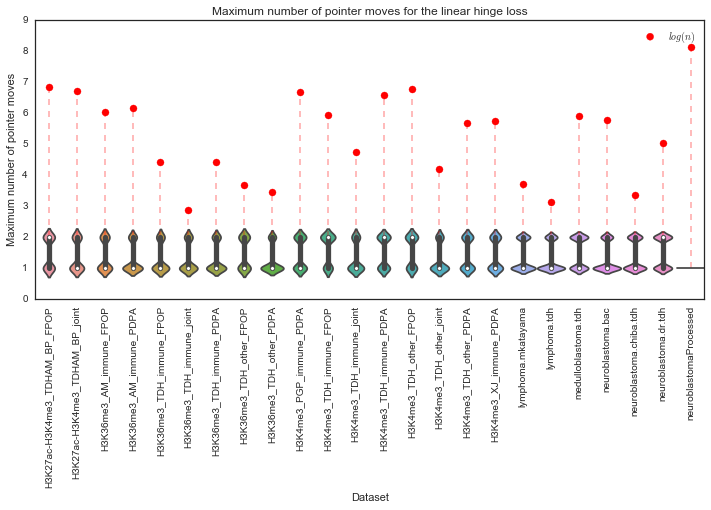

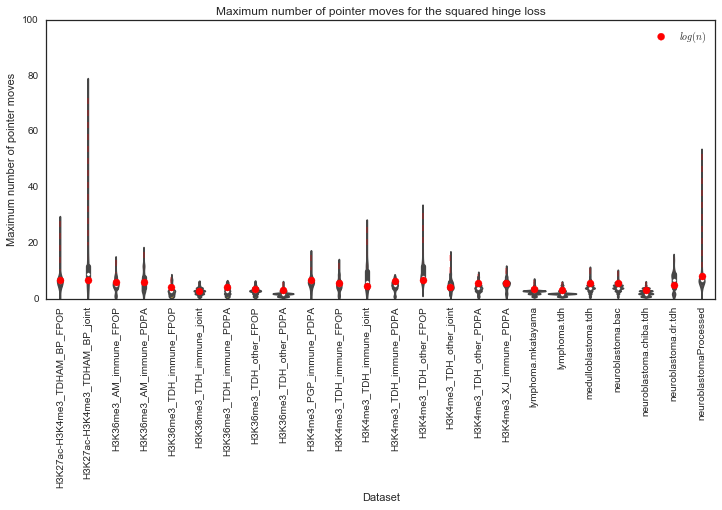

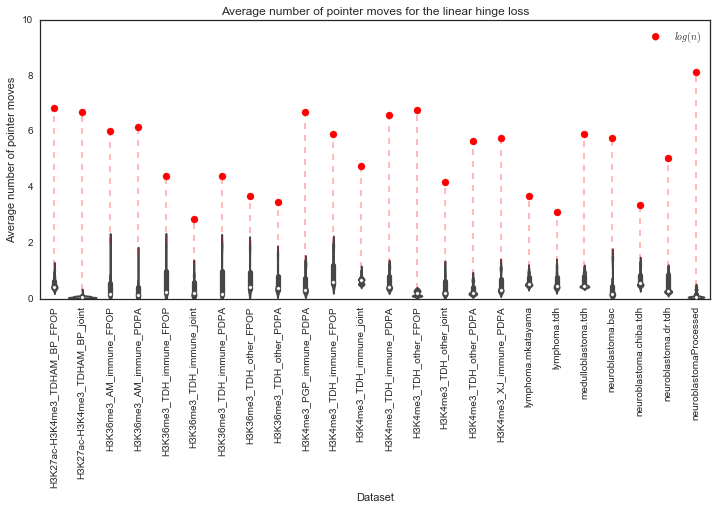

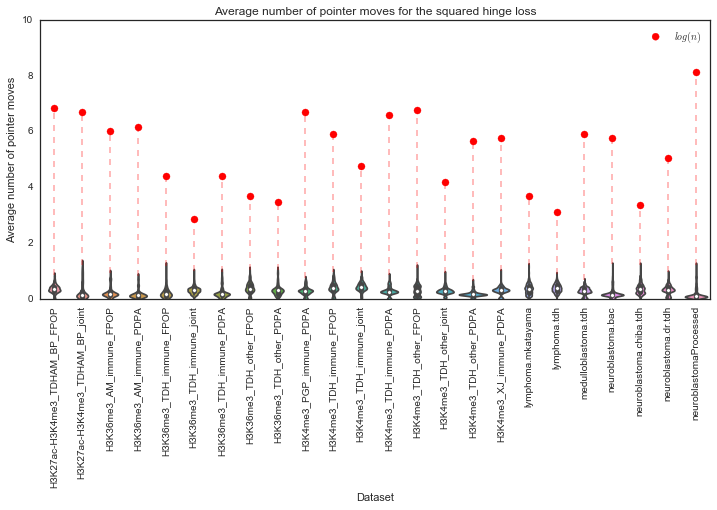

In [71]:
def plot_moves_distribution(datasets, pointer_moves_by_dataset, summary_function, save_name, axis_name, title):
    plt.clf()
    plt.gcf().set_size_inches(12, 5)
    
    # Convert to pandas dataset for seaborn plotting
    move_counts = summarize(datasets=datasets, pointer_moves_by_dataset=pointer_moves_by_dataset, 
                            func=summary_function)
    
    # Plot the distribution of moves
    sns.violinplot(x="dataset", y="pointer_moves_summarized", data=move_counts, width=1.)
    plt.xticks(rotation=90)

    # Plot the log number of examples by dataset
    for i, d in enumerate(datasets):
        ds_max_moves = move_counts["pointer_moves_summarized"].loc[move_counts["dataset"] == d.name].max()
        plt.vlines(ymin=ds_max_moves, ymax=np.log(d.n_examples), x=i, linestyles="--", color="red", alpha=0.3)
    
    plt.scatter(range(len(datasets)), [np.log(d.n_examples) for d in datasets], color="red", zorder=100, label="$log(n)$",
               s=50)

    # Plot formatting
    plt.ylabel(axis_name)
    plt.xlabel("Dataset")
    plt.ylim(ymin=0)
    plt.legend()

    # Save it!
    plt.savefig(save_name, bbox_inches="tight")
    plt.title(title)  # Don't include in the save PDF
    plt.show()
    

plot_type = "Maximum number of pointer moves"
plot_max = partial(plot_moves_distribution, summary_function=np.max, axis_name=plot_type, datasets=datasets)
plot_max(pointer_moves_by_dataset=linear_hinge_moves_by_dataset, save_name="linear_hinge_max_pointer_moves.pdf",
         title=plot_type + " for the linear hinge loss")
plot_max(pointer_moves_by_dataset=squared_hinge_moves_by_dataset, save_name="squared_hinge_max_pointer_moves.pdf",
        title=plot_type + " for the squared hinge loss")

plot_type = "Average number of pointer moves"
plot_mean = partial(plot_moves_distribution, summary_function=np.mean, axis_name=plot_type, datasets=datasets)
plot_mean(pointer_moves_by_dataset=linear_hinge_moves_by_dataset, save_name="linear_hinge_mean_pointer_moves.pdf",
          title=plot_type + " for the linear hinge loss")
plot_mean(pointer_moves_by_dataset=squared_hinge_moves_by_dataset, save_name="squared_hinge_mean_pointer_moves.pdf",
          title=plot_type + " for the squared hinge loss")

## Conclusions

* Linear hinge loss: the number of pointer moves is constant on all datasets and varies between 1 and 2.
* Squared hinge loss: the number of pointer moves is not constant, but seems to be of the order of $log(n)$. It is definitely smaller than $n$ and thus, sublinear in the number of examples in the dataset.